<a href="https://colab.research.google.com/github/Yar4ik000/DL_labs/blob/main/Morozov_DL_lab1(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение. Лабораторная работа №1. Морозов Ярослав Олегович, 317

## Постановка задачи

Во многих задачах возникает ситуация, когда у вас оказывается какой-либо датасет для работы, не обладающий прекрасными для датасетов свойствами (например миллионом уже обученных моделей на нем, большим размером и тд). В таких ситуациях одним из решений 

## Небольшая теоретическая и вводная части

Во многих задачах возникает ситуация, когда у вас оказывается какой-либо датасет для работы, не обладающий прекрасными для датасетов свойствами (например миллионом уже обученных моделей на нем, большим размером и тд), а также когда в вашем распоряжении нет десятков серверных TPU. В таких ситуациях одним из решений является использование так называемого Переноса Обучения (Transfer Learning). Ключевая идея такого подхода - использование моделей, предобученных на датасетах схожей проблематики (например, если есть желание классифицировать какие-то свои объекты, можно брать модели, обученные на ImageNet. В случае текстов, если есть задача генерации отзывов на какие-то фильмы, можно брать модели, обученные на больших объемах комментариев к википедии и тд). Смысл заключается в том, что можно просто поменять последний(-ие) слой(-и) для своих нужд и использовать веса, которые были уже получены на больших объемах данных. Такой способ позволяет сильно уменьшить количество времени, ресурсов и здоровья на свои задачи

Конкретно в данной задаче возможность использования такого подхода объясняется тем, что, во-первых, классы датасета STL10 в некотором смысле схожи с классами данных, на которых обучались модели, а во-вторых, самой идеей сверточных сетей. Свертки позволяют выделять какие-то особые части на изображениях, а обычно такие части встречаются почти всюду, что позволяет со спокойной душой пользоваться переносом обучения. Однако сущесвтует множество различных техник:

*   Продолжение обучения всей сети на новых данных, так называемый fine-tuning
*   Заморозка некоторых слоев, чтобы их веса оставались неизменными
*   Использование различных шагов обучения (learning rates) для различных слоев
*   Всевозможные комбинации вышенаписанного

Спрашивается зачем все это? Идея в том, что первые слои определяют глобальные признаки объектов, и уже чем глубже в сеть, тем более конкретные фичи выделяются, а так как мы хотим подобучить сеть на свои конкретные данные, то стоит слоям, находящимся ближе к концу делать learning rate выше. В свою очередь близким к началу слоям не очень важны конкретные признаки изображений, поэтому им можно устаналивать меньшие шаги. Также возможно, что какие-то части первых слоев вообще лучше не менять, а оставлять пришедшими с обучения на других данных


В данной работе будут исследованы следующие архитектуры:

*   ResNet18
*   VGG19_bn
*   DenseNet161

Следующие способы трансфера:

*   Differential groups. (Выделяются несколько групп из слоев сети, каждому из которых назначется lr по возрастанию)
*   Gradual Differential LRs. (Итеративное увеличение lr на каждом из слоев)
*   Fixed LR. (Обучение модели с фиксированным lr)
*   All Freeze Model, Fixed LR. (Обучение полностью замороженной модели (кроме последнего слоя) с фиксированным lr)
*   Half Freeze Model, Fixed LR. (Обучение с замороженной половиной слоев, затем фиксированный lr)
*   Half Freeze Model, Differential groups LR. (Обучение с замороженной половиной слоев, дальше идет групповое увеличние lr)


Заметим, что придумывать различные комбинации можно бесконечно, сравнить их все невозможно, поэтому были выбраны "самые диаметрально противоположные". 


## Эксперименты

###Подготовка датасета

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz

--2022-05-13 16:10:37--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  28.1MB/s    in 1m 56s  

2022-05-13 16:12:33 (21.7 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]



In [ ]:
!tar -xf /content/stl10_binary.tar.gz

Датасет находится в памяти немного не в привычном формате - сначала идут строки длины 96*96 байтов типа np.uint8 R маски, затем столько же G байтов и B. Правильность считывания подтверждается выведенным изображением

In [ ]:
with open('./data/train_X.bin', 'rb') as f:
    matrix = np.fromfile(f, dtype=np.uint8)

In [ ]:
matrix = matrix.reshape(-1, 3, 96, 96)
matrix = np.transpose(matrix, (0, 3, 2, 1))

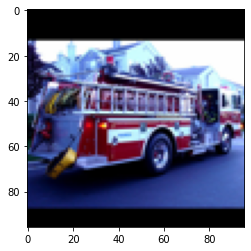

In [ ]:
plt.imshow(matrix[5])

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(
        [0.485, 0.456,0.406], 
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])])


In [ ]:
from torch.utils.data import Dataset
import os


class STLDataset(Dataset):
    def __init__(self, path, is_train=True, transforms=None):
        with open(os.path.join(path, 'train_X.bin' if is_train else 'test_X.bin'), 'rb') as file:
            self.images = np.fromfile(file, dtype=np.uint8)
            self.images = self.images.reshape(-1, 3, 96, 96) / 255
            self.images = np.transpose(self.images, (0, 2, 3, 1))

        with open(os.path.join(path, 'train_y.bin' if is_train else 'test_y.bin'), 'rb') as file:
            self.labels = np.fromfile(file, dtype=np.uint8) - 1

        self.transforms = transforms

    def __getitem__(self, idx):
        images = self.images[idx]
        if self.transforms is not None:
            images = self.transforms(images)
        
        return images.float(), self.labels[idx]      

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = STLDataset(
          path='/content/stl10_binary',
          is_train=True,
          transforms=train_transforms)

val_dataset = STLDataset(
            path='/content/stl10_binary',
            is_train=False,
            transforms=val_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=2)

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=4,
            shuffle=True, 
            num_workers=2)

### Функция для обучения нейросетей

В данной функции предоставлена также возможность проводить оценку работы модели на обучающем датасете в режиме eval, так как в режиме train результаты выходят сильно хуже

In [ ]:
from tqdm.notebook import tqdm


def train(model, train_loader, val_loader, optimizer, device='cpu', num_epochs=25, scheduler=None, eval_train=True):

    train_losses = []; train_accrs = []
    train_eval_losses = []; train_eval_accrs = []
    val_losses = []; val_accrs = []

    for epoch in tqdm(range(num_epochs)):

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()/inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item() / inputs.size(0)

        if scheduler is not None:
            scheduler.step()
        
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = running_corrects / len(train_loader)

        train_losses.append(train_epoch_loss); train_accrs.append(train_epoch_acc)

        model.eval() # <3>
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()/inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item() / inputs.size(0)

        epoch_loss = running_loss / len(val_loader)
        epoch_acc = running_corrects.double() / len(val_loader)

        val_losses.append(epoch_loss); val_accrs.append(epoch_acc)

        if eval_train:
            train_eval_loss = 0.0
            train_eval_corrects = 0

            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                train_eval_loss += loss.item()/inputs.size(0)
                train_eval_corrects += torch.sum(preds == labels.data).item() / inputs.size(0)

            train_loss = train_eval_loss / len(train_loader)
            train_acc = train_eval_corrects.double() / len(train_loader)

            train_eval_losses.append(train_loss); train_eval_accrs.append(train_acc)
        
        print(f'Epoch: {epoch}/{num_epochs} Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} '
              f'Train_eval: Loss: {train_loss if eval_train else 0 :.4f} Acc: {train_acc if eval_train else 0 :.4f} '
              f'Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        #print("Epoch: {}/{} Train: Loss: {:.4f} Acc: {:.4f}"
        #      " Val: Loss: {:.4f}"
        #      " Acc: {:.4f}".format(epoch, num_epochs, 
        #                            train_epoch_loss,
        #                            train_epoch_acc,
        #                            epoch_loss,
        #                            epoch_acc))
    
    return train_losses, train_accrs, train_eval_losses, train_eval_accrs, val_losses, val_accrs

### ResNet Trainings

In [3]:
from torch import tensor

In [59]:
#Differential Groups
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD([
                    {"params": model.conv1.parameters(), "lr": 1e-4},
                    {"params": model.bn1.parameters(), 'lr': 1e-4},
                    {"params": model.layer1.parameters(), "lr": 2e-4},
                    {"params": model.layer2.parameters(), "lr": 3e-4},
                    {"params": model.layer3.parameters(), "lr": 4e-4},
                    {"params": model.layer4.parameters(), "lr": 5e-4},
                    {"params": model.fc.parameters(), "lr": 1e-3}
                    ], lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

diff_groups_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3654 Acc: 0.5002 Train_eval: Loss: 0.2157 Acc: 0.7126 Val: Loss: 0.1708 Acc: 0.7761
Epoch: 1/25 Train: Loss: 0.2977 Acc: 0.6054 Train_eval: Loss: 0.2200 Acc: 0.7164 Val: Loss: 0.1948 Acc: 0.7762
Epoch: 2/25 Train: Loss: 0.2849 Acc: 0.6306 Train_eval: Loss: 0.1731 Acc: 0.7664 Val: Loss: 0.1607 Acc: 0.7990
Epoch: 3/25 Train: Loss: 0.2622 Acc: 0.6566 Train_eval: Loss: 0.1906 Acc: 0.7596 Val: Loss: 0.1976 Acc: 0.7908
Epoch: 4/25 Train: Loss: 0.2492 Acc: 0.6788 Train_eval: Loss: 0.1775 Acc: 0.7662 Val: Loss: 0.1572 Acc: 0.8095
Epoch: 5/25 Train: Loss: 0.2365 Acc: 0.6938 Train_eval: Loss: 0.1467 Acc: 0.7972 Val: Loss: 0.1448 Acc: 0.8257
Epoch: 6/25 Train: Loss: 0.2288 Acc: 0.6952 Train_eval: Loss: 0.1286 Acc: 0.8270 Val: Loss: 0.1133 Acc: 0.8581
Epoch: 7/25 Train: Loss: 0.1760 Acc: 0.7600 Train_eval: Loss: 0.0929 Acc: 0.8672 Val: Loss: 0.0956 Acc: 0.8808
Epoch: 8/25 Train: Loss: 0.1625 Acc: 0.7790 Train_eval: Loss: 0.0906 Acc: 0.8778 Val: Loss: 0.0956 Acc: 0.8811
E

In [60]:
#Gradual Differential LRs
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

length = 0
for name, param in model.named_parameters():
    length += 1

length -= 1

gradual_rates = []
for i, (name, params) in enumerate(model.named_parameters()):
    gradual_rates.append({'params': params, 'lr': 1e-4 + ((1e-3 - 1e-4) / length) * i})

optimizer = optim.SGD(gradual_rates, lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

gradual_rates_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3832 Acc: 0.4818 Train_eval: Loss: 0.2539 Acc: 0.6616 Val: Loss: 0.2336 Acc: 0.7110
Epoch: 1/25 Train: Loss: 0.3106 Acc: 0.5958 Train_eval: Loss: 0.1972 Acc: 0.7394 Val: Loss: 0.1637 Acc: 0.8031
Epoch: 2/25 Train: Loss: 0.2843 Acc: 0.6234 Train_eval: Loss: 0.1921 Acc: 0.7392 Val: Loss: 0.1719 Acc: 0.7849
Epoch: 3/25 Train: Loss: 0.2637 Acc: 0.6606 Train_eval: Loss: 0.1684 Acc: 0.7812 Val: Loss: 0.1500 Acc: 0.8179
Epoch: 4/25 Train: Loss: 0.2490 Acc: 0.6828 Train_eval: Loss: 0.1791 Acc: 0.7740 Val: Loss: 0.1737 Acc: 0.8067
Epoch: 5/25 Train: Loss: 0.2399 Acc: 0.6896 Train_eval: Loss: 0.1541 Acc: 0.7978 Val: Loss: 0.1453 Acc: 0.8283
Epoch: 6/25 Train: Loss: 0.2324 Acc: 0.6932 Train_eval: Loss: 0.1429 Acc: 0.8136 Val: Loss: 0.1280 Acc: 0.8439
Epoch: 7/25 Train: Loss: 0.1779 Acc: 0.7616 Train_eval: Loss: 0.1143 Acc: 0.8508 Val: Loss: 0.1129 Acc: 0.8623
Epoch: 8/25 Train: Loss: 0.1652 Acc: 0.7850 Train_eval: Loss: 0.0931 Acc: 0.8756 Val: Loss: 0.0915 Acc: 0.8805
E

In [61]:
#Fixed LR
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

fixed_lr_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3768 Acc: 0.4576 Train_eval: Loss: 0.2232 Acc: 0.6910 Val: Loss: 0.1889 Acc: 0.7442
Epoch: 1/25 Train: Loss: 0.3096 Acc: 0.5698 Train_eval: Loss: 0.1858 Acc: 0.7366 Val: Loss: 0.1575 Acc: 0.7894
Epoch: 2/25 Train: Loss: 0.2801 Acc: 0.6182 Train_eval: Loss: 0.1692 Acc: 0.7716 Val: Loss: 0.1445 Acc: 0.8015
Epoch: 3/25 Train: Loss: 0.2555 Acc: 0.6526 Train_eval: Loss: 0.1561 Acc: 0.7836 Val: Loss: 0.1307 Acc: 0.8237
Epoch: 4/25 Train: Loss: 0.2399 Acc: 0.6824 Train_eval: Loss: 0.1629 Acc: 0.7830 Val: Loss: 0.1584 Acc: 0.8003
Epoch: 5/25 Train: Loss: 0.2409 Acc: 0.6712 Train_eval: Loss: 0.1458 Acc: 0.8016 Val: Loss: 0.1299 Acc: 0.8335
Epoch: 6/25 Train: Loss: 0.2236 Acc: 0.6960 Train_eval: Loss: 0.1455 Acc: 0.7962 Val: Loss: 0.1293 Acc: 0.8316
Epoch: 7/25 Train: Loss: 0.1799 Acc: 0.7632 Train_eval: Loss: 0.1086 Acc: 0.8488 Val: Loss: 0.1015 Acc: 0.8660
Epoch: 8/25 Train: Loss: 0.1753 Acc: 0.7702 Train_eval: Loss: 0.0990 Acc: 0.8634 Val: Loss: 0.0964 Acc: 0.8758
E

In [62]:
#All Freeze Model
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

for name, param in model.named_parameters():
    if ("bn" not in name and "fc" not in name):
        param.requires_grad = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

all_freeze_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3841 Acc: 0.4532 Train_eval: Loss: 0.2100 Acc: 0.6998 Val: Loss: 0.1757 Acc: 0.7514
Epoch: 1/25 Train: Loss: 0.2944 Acc: 0.5832 Train_eval: Loss: 0.1754 Acc: 0.7540 Val: Loss: 0.1470 Acc: 0.7904
Epoch: 2/25 Train: Loss: 0.2769 Acc: 0.6208 Train_eval: Loss: 0.1728 Acc: 0.7604 Val: Loss: 0.1321 Acc: 0.8195
Epoch: 3/25 Train: Loss: 0.2751 Acc: 0.6188 Train_eval: Loss: 0.1838 Acc: 0.7392 Val: Loss: 0.1529 Acc: 0.7931
Epoch: 4/25 Train: Loss: 0.2652 Acc: 0.6352 Train_eval: Loss: 0.1576 Acc: 0.7728 Val: Loss: 0.1206 Acc: 0.8311
Epoch: 5/25 Train: Loss: 0.2639 Acc: 0.6358 Train_eval: Loss: 0.1503 Acc: 0.7924 Val: Loss: 0.1175 Acc: 0.8357
Epoch: 6/25 Train: Loss: 0.2465 Acc: 0.6638 Train_eval: Loss: 0.1688 Acc: 0.7676 Val: Loss: 0.1392 Acc: 0.8125
Epoch: 7/25 Train: Loss: 0.2299 Acc: 0.6822 Train_eval: Loss: 0.1398 Acc: 0.8014 Val: Loss: 0.1090 Acc: 0.8489
Epoch: 8/25 Train: Loss: 0.2309 Acc: 0.6912 Train_eval: Loss: 0.1362 Acc: 0.8076 Val: Loss: 0.1041 Acc: 0.8533
E

In [63]:
#Half Freeze Model, Fixed Lr
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

for name, param in model.layer1.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

for name, param in model.layer2.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

for name, param in model.conv1.named_parameters():
    param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3411 Acc: 0.5184 Train_eval: Loss: 0.1800 Acc: 0.7528 Val: Loss: 0.1524 Acc: 0.7924
Epoch: 1/25 Train: Loss: 0.2627 Acc: 0.6386 Train_eval: Loss: 0.1567 Acc: 0.7800 Val: Loss: 0.1230 Acc: 0.8295
Epoch: 2/25 Train: Loss: 0.2406 Acc: 0.6846 Train_eval: Loss: 0.1286 Acc: 0.8136 Val: Loss: 0.1184 Acc: 0.8451
Epoch: 3/25 Train: Loss: 0.2283 Acc: 0.6926 Train_eval: Loss: 0.1189 Acc: 0.8388 Val: Loss: 0.1048 Acc: 0.8665
Epoch: 4/25 Train: Loss: 0.2199 Acc: 0.7046 Train_eval: Loss: 0.1173 Acc: 0.8400 Val: Loss: 0.0976 Acc: 0.8682
Epoch: 5/25 Train: Loss: 0.1974 Acc: 0.7338 Train_eval: Loss: 0.1154 Acc: 0.8402 Val: Loss: 0.1108 Acc: 0.8598
Epoch: 6/25 Train: Loss: 0.1935 Acc: 0.7484 Train_eval: Loss: 0.1123 Acc: 0.8440 Val: Loss: 0.1037 Acc: 0.8698
Epoch: 7/25 Train: Loss: 0.1667 Acc: 0.7842 Train_eval: Loss: 0.0930 Acc: 0.8734 Val: Loss: 0.0888 Acc: 0.8820
Epoch: 8/25 Train: Loss: 0.1616 Acc: 0.7880 Train_eval: Loss: 0.0886 Acc: 0.8750 Val: Loss: 0.0845 Acc: 0.8911
E

In [64]:
#Half Freeze Model, Differential Groups Lr
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

for name, param in model.layer1.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

for name, param in model.layer2.named_parameters():
    if "bn" not in name:
        param.requires_grad = False

for name, param in model.conv1.named_parameters():
    param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD([
                    {"params": model.bn1.parameters(), 'lr': 1e-4},
                    {"params": model.layer3.parameters(), "lr": 1e-4},
                    {"params": model.layer4.parameters(), "lr": 2.5e-4},
                    {"params": model.fc.parameters(), "lr": 5e-4}
                    ], lr=5e-4, momentum=0.9)


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_groups_lr_resnet = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler)

Epoch: 0/25 Train: Loss: 0.3675 Acc: 0.4842 Train_eval: Loss: 0.1838 Acc: 0.7376 Val: Loss: 0.1438 Acc: 0.7985
Epoch: 1/25 Train: Loss: 0.2806 Acc: 0.6062 Train_eval: Loss: 0.1666 Acc: 0.7650 Val: Loss: 0.1300 Acc: 0.8249
Epoch: 2/25 Train: Loss: 0.2604 Acc: 0.6518 Train_eval: Loss: 0.1413 Acc: 0.8054 Val: Loss: 0.1203 Acc: 0.8400
Epoch: 3/25 Train: Loss: 0.2343 Acc: 0.6796 Train_eval: Loss: 0.1215 Acc: 0.8282 Val: Loss: 0.1039 Acc: 0.8568
Epoch: 4/25 Train: Loss: 0.2294 Acc: 0.6882 Train_eval: Loss: 0.1182 Acc: 0.8364 Val: Loss: 0.0983 Acc: 0.8694
Epoch: 5/25 Train: Loss: 0.2189 Acc: 0.7060 Train_eval: Loss: 0.1106 Acc: 0.8482 Val: Loss: 0.0979 Acc: 0.8724
Epoch: 6/25 Train: Loss: 0.2081 Acc: 0.7192 Train_eval: Loss: 0.1147 Acc: 0.8344 Val: Loss: 0.0969 Acc: 0.8744
Epoch: 7/25 Train: Loss: 0.1832 Acc: 0.7528 Train_eval: Loss: 0.1001 Acc: 0.8628 Val: Loss: 0.0887 Acc: 0.8831
Epoch: 8/25 Train: Loss: 0.1770 Acc: 0.7580 Train_eval: Loss: 0.0974 Acc: 0.8620 Val: Loss: 0.0862 Acc: 0.8839
E

### Plot graphics function

In [118]:
# Здесь нечестным образом пользуюсь привилегиями коллаба были использованы переменные, 
# определенные в коде после. Так что для корректного исполнения нужно либо заполнять
# словарик последовательно, либо сначала запустить клетки ниже

results = {
    'diff_groups_resnet': diff_groups_resnet,
    'gradual_rates_resnet': gradual_rates_resnet,
    'fixed_lr_resnet': fixed_lr_resnet,
    'all_freeze_resnet': all_freeze_resnet,
    'half_freeze_resnet': half_freeze_resnet,
    'half_freeze_groups_lr_resnet': half_freeze_groups_lr_resnet,
    'diff_groups_vgg': diff_groups_vgg,
    'gradual_rates_vgg': gradual_rates_vgg,
    'fixed_lr_vgg': fixed_lr_vgg,
    'all_freeze_vgg': all_freeze_vgg,
    'half_freeze_vgg': half_freeze_vgg,
    'half_freeze_groups_lr_vgg': half_freeze_groups_lr_vgg,
    'diff_groups_densenet': diff_groups_densenet,
    'gradual_rates_densenet': gradual_rates_densenet,
    'fixed_lr_densenet': fixed_lr_densenet,
    'all_freeze_densenet': all_freeze_densenet,
    'half_freeze_densenet': half_freeze_densenet,
    'half_freeze_groups_lr_densenet': half_freeze_groups_lr_densenet,
}


def plot_graphics(suffix=''):
    methods = ['diff_groups_', 'gradual_rates_', 'fixed_lr_', 
               'all_freeze_', 'half_freeze_', 'half_freeze_groups_lr_']

    for i, mode in enumerate(['Train', 'Train_eval', 'Test']):
        plt.figure(figsize=(15, 8))
        plt.title(f'{mode} Losses', fontsize=20)
        plt.xlabel('Epoch', fontsize=15)
        plt.ylabel('Loss', fontsize=15)

        for method in methods:
            plt.plot(results[f'{method}{suffix}'][i * 2], label=method, linewidth=2.5, marker='.')
        plt.grid(True)
        plt.legend(prop={'size': 15})

        plt.figure(figsize=(15, 8))
        plt.title(f'{mode} Accuracies', fontsize=20)
        plt.xlabel('Epoch', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)

        for method in methods:
            plt.plot(results[f'{method}{suffix}'][i * 2 + 1], label=method, linewidth=2.5, marker='.')
        plt.grid(True)
        plt.legend(prop={'size': 15})

### ResNet Graphics

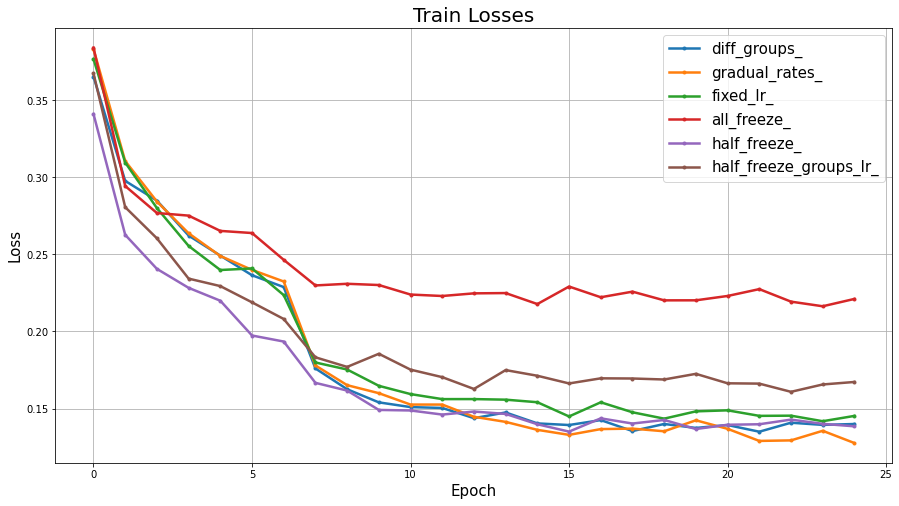

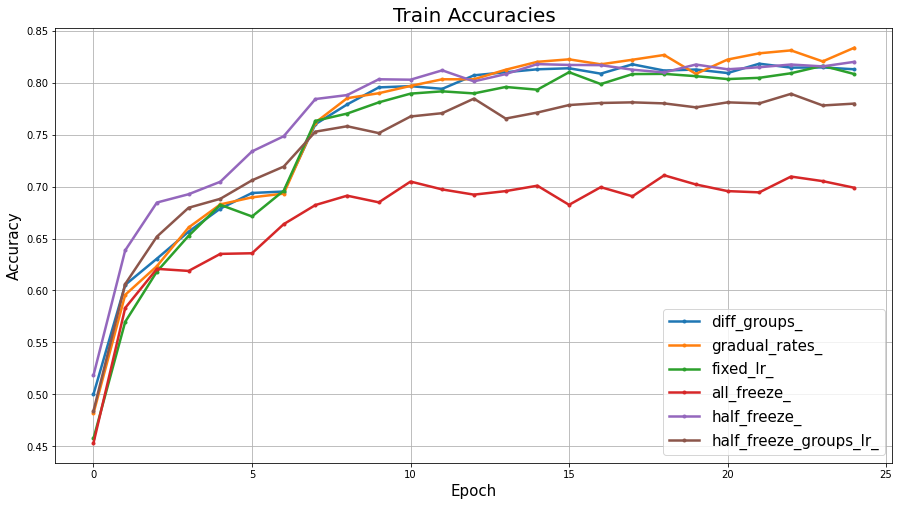

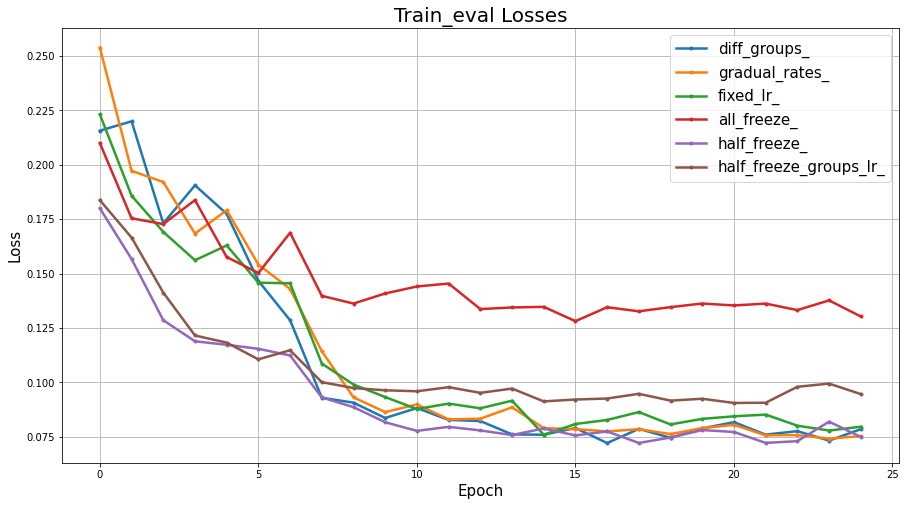

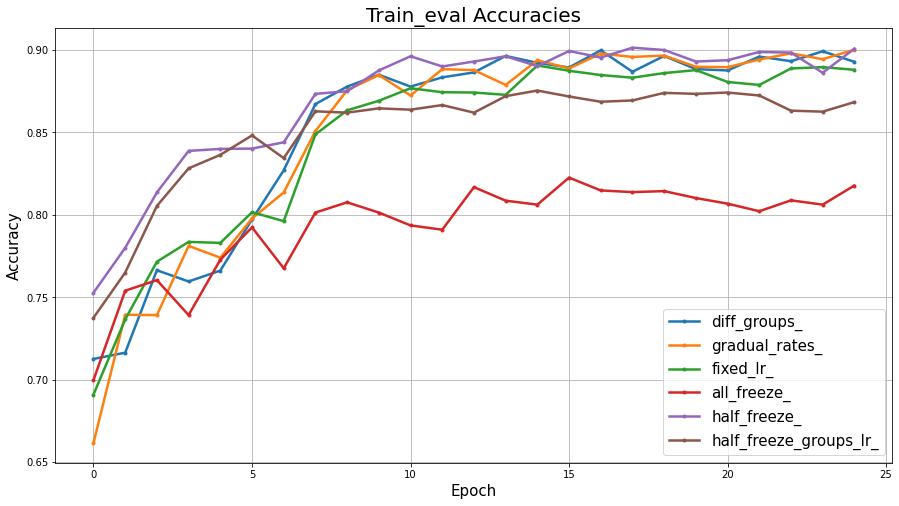

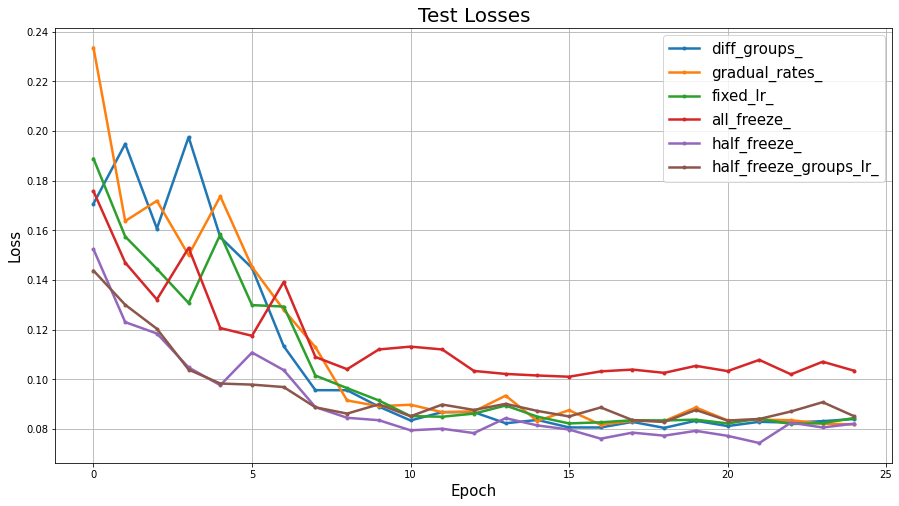

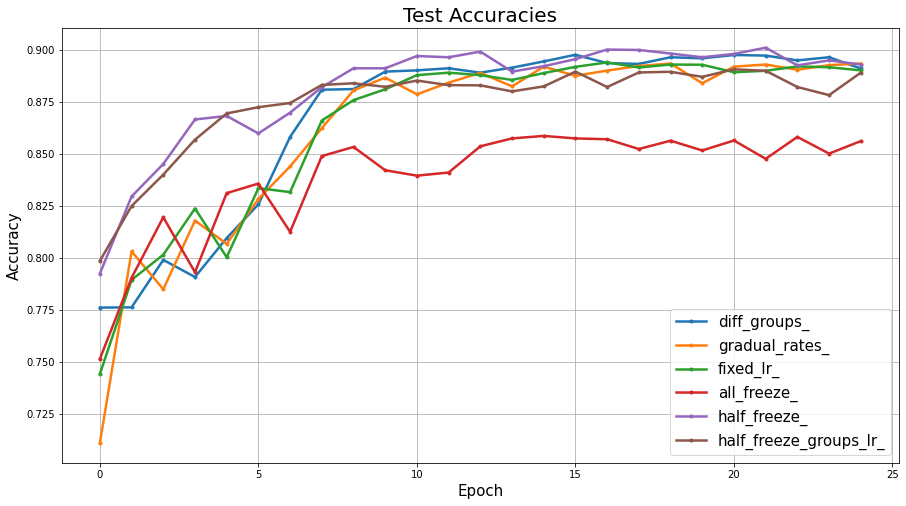

In [55]:
plot_graphics('resnet')

Как видно идея полной заморозки себя не оправдала, также после 10ой эпохи все результаты выходят на плато. При этом способ половинной заморозки с дифференциальными learning rates оказывается хуже других (кроме полной заморозки). Другие же находятся примерно на одном уровне

### VGG

Многоуважаемые создатели архитектуры чем-то похожи на студентов ММП - видимо они тоже делали все в последний день, так как иначе не объяснить просто подряд идущие слои без названий. Из за этого при заморозке слоев код может выглядеть слегка костыльным и, возможно, не очень оптимальным.

Стоит отметить, что для разумного времени обучения и возможности примерно сравнить (а также для контроля переобучения) данная архитектура, а также последующая, обучаются на 15 эпохах

In [65]:
#Differential Groups Lr
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

params_groups = []
learning_rates = [1e-4, 2e-4, 3e-4, 4e-4]
for i, (name, param) in enumerate(model.named_parameters()):
    if i == 64:
        break
    params_groups.append({'params': param, 'lr': learning_rates[i // 16]})
    
for i, (name, param) in enumerate(model.classifier.named_parameters()):
    if i == 4:
        break
    params_groups.append({'params': param, 'lr': 5e-4})

params_groups.append({'params': model.classifier[6].parameters(), 'lr': 1e-3})

optimizer = optim.SGD(params_groups, lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

diff_groups_vgg = train(model, 
                        train_loader, 
                        val_loader, 
                        optimizer, 
                        device, 
                        eval_train=True,
                        scheduler=exp_lr_scheduler,
                        num_epochs=15)

Epoch: 0/15 Train: Loss: 0.2923 Acc: 0.5884 Train_eval: Loss: 0.1673 Acc: 0.7640 Val: Loss: 0.1402 Acc: 0.8051
Epoch: 1/15 Train: Loss: 0.2112 Acc: 0.7066 Train_eval: Loss: 0.1370 Acc: 0.8102 Val: Loss: 0.1015 Acc: 0.8606
Epoch: 2/15 Train: Loss: 0.1828 Acc: 0.7450 Train_eval: Loss: 0.1340 Acc: 0.8154 Val: Loss: 0.1083 Acc: 0.8536
Epoch: 3/15 Train: Loss: 0.1671 Acc: 0.7592 Train_eval: Loss: 0.1038 Acc: 0.8536 Val: Loss: 0.0859 Acc: 0.8815
Epoch: 4/15 Train: Loss: 0.1505 Acc: 0.7896 Train_eval: Loss: 0.1080 Acc: 0.8494 Val: Loss: 0.1050 Acc: 0.8609
Epoch: 5/15 Train: Loss: 0.1481 Acc: 0.7946 Train_eval: Loss: 0.0942 Acc: 0.8678 Val: Loss: 0.0797 Acc: 0.8886
Epoch: 6/15 Train: Loss: 0.1345 Acc: 0.8086 Train_eval: Loss: 0.1065 Acc: 0.8504 Val: Loss: 0.0911 Acc: 0.8746
Epoch: 7/15 Train: Loss: 0.1199 Acc: 0.8380 Train_eval: Loss: 0.0788 Acc: 0.8930 Val: Loss: 0.0696 Acc: 0.9052
Epoch: 8/15 Train: Loss: 0.1072 Acc: 0.8490 Train_eval: Loss: 0.0702 Acc: 0.8974 Val: Loss: 0.0668 Acc: 0.9088
E

In [67]:
#Gradual Differential Lrs
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

length = 0
for name, param in model.named_parameters():
    length += 1

length -= 1

gradual_rates = []
for i, (name, params) in enumerate(model.named_parameters()):
    gradual_rates.append({'params': params, 'lr': 1e-4 + ((1e-3 - 1e-4) / length) * i})

optimizer = optim.SGD(gradual_rates, lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

gradual_rates_vgg = train(model, 
                            train_loader, 
                            val_loader, 
                            optimizer, 
                            device, 
                            eval_train=True,
                            scheduler=exp_lr_scheduler,
                            num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3174 Acc: 0.5512 Train_eval: Loss: 0.1959 Acc: 0.7318 Val: Loss: 0.1697 Acc: 0.7752
Epoch: 1/15 Train: Loss: 0.2486 Acc: 0.6486 Train_eval: Loss: 0.1816 Acc: 0.7472 Val: Loss: 0.1460 Acc: 0.8053
Epoch: 2/15 Train: Loss: 0.2260 Acc: 0.6862 Train_eval: Loss: 0.1518 Acc: 0.7842 Val: Loss: 0.1292 Acc: 0.8243
Epoch: 3/15 Train: Loss: 0.2070 Acc: 0.7088 Train_eval: Loss: 0.1506 Acc: 0.7948 Val: Loss: 0.1226 Acc: 0.8350
Epoch: 4/15 Train: Loss: 0.1818 Acc: 0.7414 Train_eval: Loss: 0.1411 Acc: 0.8158 Val: Loss: 0.1171 Acc: 0.8541
Epoch: 5/15 Train: Loss: 0.1799 Acc: 0.7544 Train_eval: Loss: 0.1149 Acc: 0.8416 Val: Loss: 0.0989 Acc: 0.8685
Epoch: 6/15 Train: Loss: 0.1603 Acc: 0.7782 Train_eval: Loss: 0.1834 Acc: 0.7786 Val: Loss: 0.2043 Acc: 0.7802
Epoch: 7/15 Train: Loss: 0.1333 Acc: 0.8096 Train_eval: Loss: 0.0854 Acc: 0.8750 Val: Loss: 0.0794 Acc: 0.8945
Epoch: 8/15 Train: Loss: 0.1149 Acc: 0.8354 Train_eval: Loss: 0.0754 Acc: 0.8956 Val: Loss: 0.0771 Acc: 0.9019
E

In [69]:
#Fixed Lr
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

fixed_lr_vgg = train(model, 
                        train_loader, 
                        val_loader, 
                        optimizer, 
                        device, 
                        eval_train=True,
                        scheduler=exp_lr_scheduler,
                        num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3152 Acc: 0.5484 Train_eval: Loss: 0.1984 Acc: 0.7192 Val: Loss: 0.1524 Acc: 0.7920
Epoch: 1/15 Train: Loss: 0.2353 Acc: 0.6680 Train_eval: Loss: 0.1739 Acc: 0.7516 Val: Loss: 0.1377 Acc: 0.8106
Epoch: 2/15 Train: Loss: 0.2118 Acc: 0.6946 Train_eval: Loss: 0.1346 Acc: 0.8100 Val: Loss: 0.1098 Acc: 0.8409
Epoch: 3/15 Train: Loss: 0.1874 Acc: 0.7322 Train_eval: Loss: 0.1322 Acc: 0.8200 Val: Loss: 0.1126 Acc: 0.8486
Epoch: 4/15 Train: Loss: 0.1726 Acc: 0.7544 Train_eval: Loss: 0.1239 Acc: 0.8302 Val: Loss: 0.1084 Acc: 0.8511
Epoch: 5/15 Train: Loss: 0.1586 Acc: 0.7758 Train_eval: Loss: 0.1204 Acc: 0.8276 Val: Loss: 0.1122 Acc: 0.8590
Epoch: 6/15 Train: Loss: 0.1547 Acc: 0.7844 Train_eval: Loss: 0.1051 Acc: 0.8526 Val: Loss: 0.0888 Acc: 0.8799
Epoch: 7/15 Train: Loss: 0.1235 Acc: 0.8290 Train_eval: Loss: 0.0801 Acc: 0.8894 Val: Loss: 0.0762 Acc: 0.8968
Epoch: 8/15 Train: Loss: 0.1165 Acc: 0.8420 Train_eval: Loss: 0.0782 Acc: 0.8954 Val: Loss: 0.0727 Acc: 0.9032
E

In [70]:
#All Freeze Model
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

bn_s = [1, 1, 4, 4, 8, 8, 11, 11, 15, 15, 18, 18, 21, 21, 24, 24, 28, 28, 31, 31, 34, 34, 37, 37, 41, 41, 44, 44, 47, 47, 50, 50]
bn_s = bn_s[::-1]

for i, (name, param) in enumerate(model.named_parameters()):
    if i == 68:
        break
    if bn_s and name[9:].startswith(str(bn_s[-1])):
        bn_s.pop()
    else:
        param.requires_grad = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

all_freeze_vgg = train(model, 
                       train_loader, 
                       val_loader, 
                       optimizer, 
                       device, 
                       eval_train=True,
                       scheduler=exp_lr_scheduler,
                       num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3201 Acc: 0.5420 Train_eval: Loss: 0.1911 Acc: 0.7332 Val: Loss: 0.1472 Acc: 0.7956
Epoch: 1/15 Train: Loss: 0.2548 Acc: 0.6366 Train_eval: Loss: 0.1633 Acc: 0.7702 Val: Loss: 0.1202 Acc: 0.8331
Epoch: 2/15 Train: Loss: 0.2183 Acc: 0.6944 Train_eval: Loss: 0.1617 Acc: 0.7650 Val: Loss: 0.1246 Acc: 0.8221
Epoch: 3/15 Train: Loss: 0.2101 Acc: 0.7040 Train_eval: Loss: 0.1481 Acc: 0.7890 Val: Loss: 0.1094 Acc: 0.8434
Epoch: 4/15 Train: Loss: 0.2154 Acc: 0.6928 Train_eval: Loss: 0.1442 Acc: 0.7970 Val: Loss: 0.1096 Acc: 0.8444
Epoch: 5/15 Train: Loss: 0.1999 Acc: 0.7188 Train_eval: Loss: 0.1387 Acc: 0.8038 Val: Loss: 0.1036 Acc: 0.8546
Epoch: 6/15 Train: Loss: 0.1925 Acc: 0.7274 Train_eval: Loss: 0.1293 Acc: 0.8186 Val: Loss: 0.1030 Acc: 0.8540
Epoch: 7/15 Train: Loss: 0.1829 Acc: 0.7450 Train_eval: Loss: 0.1278 Acc: 0.8242 Val: Loss: 0.0973 Acc: 0.8618
Epoch: 8/15 Train: Loss: 0.1812 Acc: 0.7468 Train_eval: Loss: 0.1322 Acc: 0.8114 Val: Loss: 0.1005 Acc: 0.8561
E

In [71]:
#Half Freeze Model, Fixed Lr
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

bn_s = [1, 1, 4, 4, 8, 8, 11, 11, 15, 15, 18, 18, 21, 21, 24, 24, 28, 28, 31, 31]
bn_s = bn_s[::-1]

for i, (name, param) in enumerate(model.named_parameters()):
    if i == 34:
        break
    if bn_s and name[9:].startswith(str(bn_s[-1])):
        bn_s.pop()
    else:
        param.requires_grad = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_vgg = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler,
                          num_epochs=15)

Epoch: 0/15 Train: Loss: 0.2870 Acc: 0.5812 Train_eval: Loss: 0.1596 Acc: 0.7746 Val: Loss: 0.1221 Acc: 0.8327
Epoch: 1/15 Train: Loss: 0.2026 Acc: 0.7138 Train_eval: Loss: 0.1332 Acc: 0.8184 Val: Loss: 0.1083 Acc: 0.8488
Epoch: 2/15 Train: Loss: 0.1746 Acc: 0.7552 Train_eval: Loss: 0.1094 Acc: 0.8412 Val: Loss: 0.0867 Acc: 0.8795
Epoch: 3/15 Train: Loss: 0.1597 Acc: 0.7784 Train_eval: Loss: 0.1107 Acc: 0.8426 Val: Loss: 0.0973 Acc: 0.8692
Epoch: 4/15 Train: Loss: 0.1482 Acc: 0.7910 Train_eval: Loss: 0.0974 Acc: 0.8660 Val: Loss: 0.0859 Acc: 0.8830
Epoch: 5/15 Train: Loss: 0.1355 Acc: 0.8122 Train_eval: Loss: 0.0938 Acc: 0.8706 Val: Loss: 0.0875 Acc: 0.8880
Epoch: 6/15 Train: Loss: 0.1303 Acc: 0.8200 Train_eval: Loss: 0.0874 Acc: 0.8818 Val: Loss: 0.0918 Acc: 0.8811
Epoch: 7/15 Train: Loss: 0.1094 Acc: 0.8480 Train_eval: Loss: 0.0726 Acc: 0.8972 Val: Loss: 0.0732 Acc: 0.9032
Epoch: 8/15 Train: Loss: 0.1077 Acc: 0.8510 Train_eval: Loss: 0.0646 Acc: 0.9114 Val: Loss: 0.0675 Acc: 0.9104
E

In [72]:
#Half Freeze Model, Differential Groups Lr
model = models.vgg19_bn(pretrained=True)

num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

bn_s = [1, 1, 4, 4, 8, 8, 11, 11, 15, 15, 18, 18, 21, 21, 24, 24, 28, 28, 31, 31]
bn_s = bn_s[::-1]

for i, (name, param) in enumerate(model.named_parameters()):
    if i == 34:
        break
    if bn_s and name[9:].startswith(str(bn_s[-1])):
        bn_s.pop()
    else:
        param.requires_grad = False

        

params_groups = []
learning_rates = [1e-4, 2e-4, 3e-4, 4e-4]
for i, (name, param) in enumerate(model.named_parameters()):
    if i < 34:
        continue
    if i == 68:
        break
    params_groups.append({'params': param, 'lr': learning_rates[(i - 34) // 9]})
    
for i, (name, param) in enumerate(model.classifier.named_parameters()):
    if i == 4:
        break
    params_groups.append({'params': param, 'lr': 5e-4})

params_groups.append({'params': model.classifier[6].parameters(), 'lr': 1e-3})


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_groups_lr_vgg = train(model, 
                          train_loader, 
                          val_loader, 
                          optimizer, 
                          device, 
                          eval_train=True,
                          scheduler=exp_lr_scheduler,
                          num_epochs=15)

Epoch: 0/15 Train: Loss: 0.2867 Acc: 0.5918 Train_eval: Loss: 0.1499 Acc: 0.7952 Val: Loss: 0.1086 Acc: 0.8518
Epoch: 1/15 Train: Loss: 0.2065 Acc: 0.7042 Train_eval: Loss: 0.1301 Acc: 0.8226 Val: Loss: 0.0969 Acc: 0.8645
Epoch: 2/15 Train: Loss: 0.1788 Acc: 0.7522 Train_eval: Loss: 0.1132 Acc: 0.8350 Val: Loss: 0.0883 Acc: 0.8772
Epoch: 3/15 Train: Loss: 0.1598 Acc: 0.7736 Train_eval: Loss: 0.1113 Acc: 0.8420 Val: Loss: 0.0935 Acc: 0.8752
Epoch: 4/15 Train: Loss: 0.1446 Acc: 0.7960 Train_eval: Loss: 0.0961 Acc: 0.8652 Val: Loss: 0.0862 Acc: 0.8838
Epoch: 5/15 Train: Loss: 0.1346 Acc: 0.8076 Train_eval: Loss: 0.0872 Acc: 0.8762 Val: Loss: 0.0796 Acc: 0.8915
Epoch: 6/15 Train: Loss: 0.1283 Acc: 0.8204 Train_eval: Loss: 0.0944 Acc: 0.8720 Val: Loss: 0.0865 Acc: 0.8866
Epoch: 7/15 Train: Loss: 0.1094 Acc: 0.8480 Train_eval: Loss: 0.0750 Acc: 0.8966 Val: Loss: 0.0691 Acc: 0.9050
Epoch: 8/15 Train: Loss: 0.1034 Acc: 0.8528 Train_eval: Loss: 0.0682 Acc: 0.9052 Val: Loss: 0.0689 Acc: 0.9084
E

### VGG Graphics

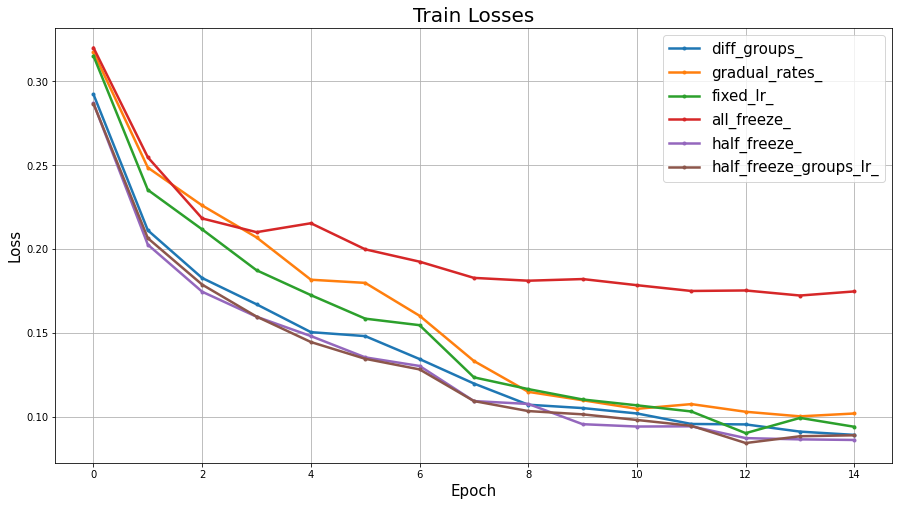

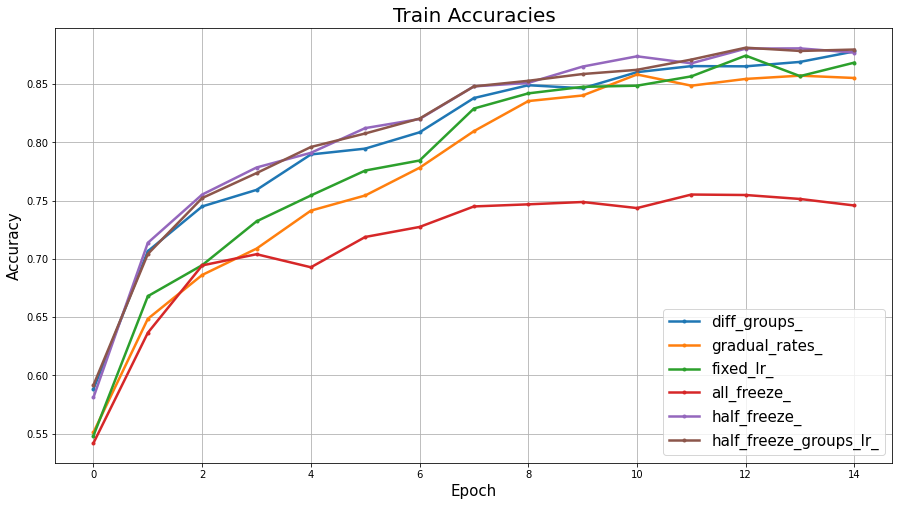

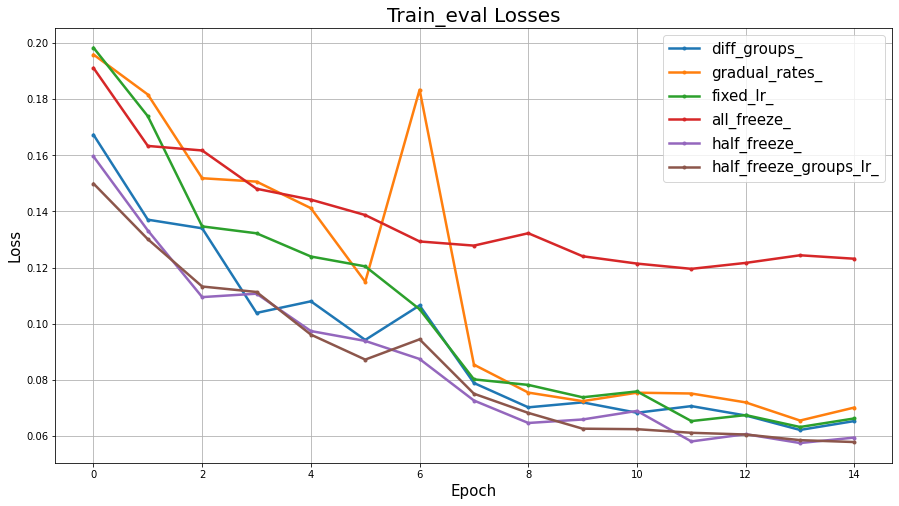

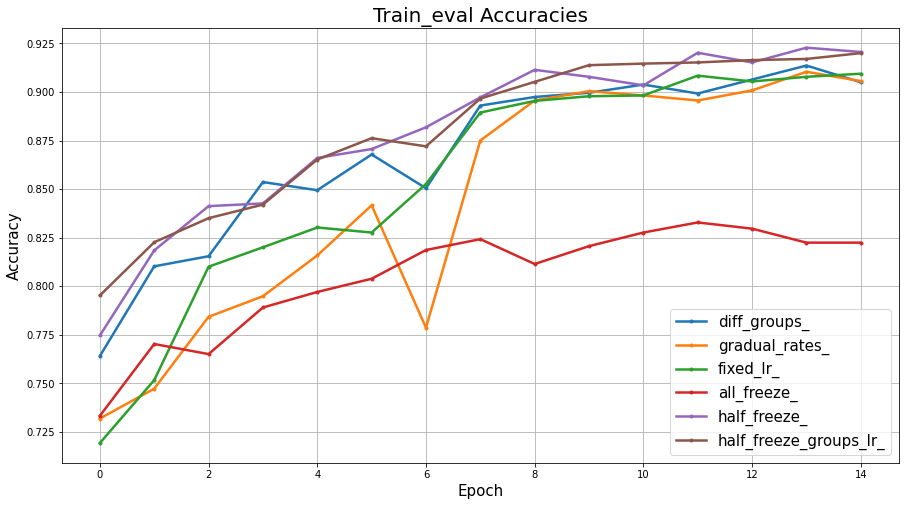

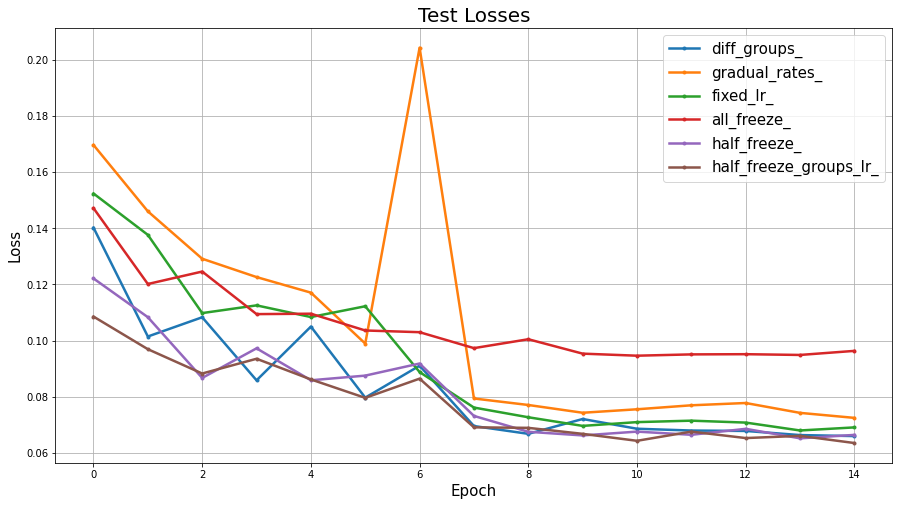

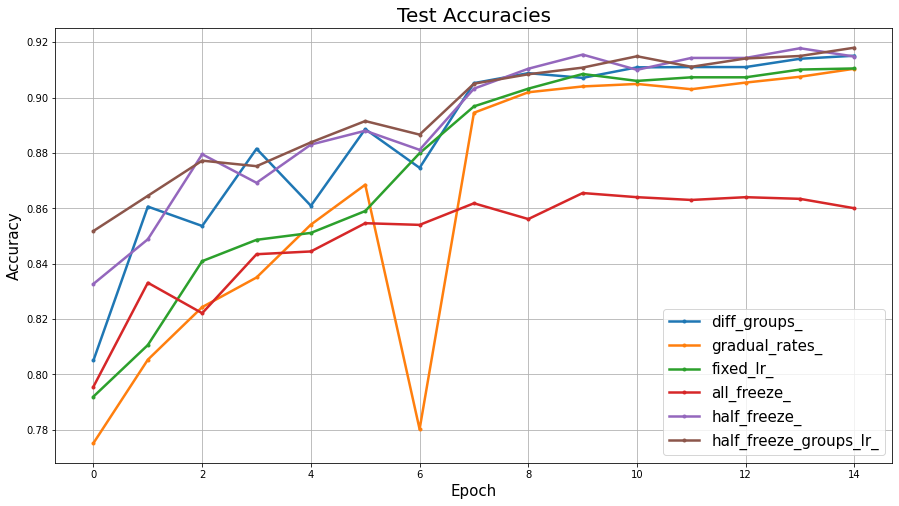

In [56]:
plot_graphics('vgg')

Интересная особенность у рассмотренных способов для модели VGG. Получается что все методы без заморозки слоев (за исключением полной, он, опять, хуже всех), оказываются хуже, чем с заморозкой, причем также у них наблюдаются сильные скачки качества вниз (и росты лосса вверх), в то время как модели с заморозкой ведут сбея после пары слоев более-менее ровно. 

### DenseNet

In [114]:
#Differential Groups Lr
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

optimizer = optim.SGD([
    {'params': model.features.conv0.parameters(), 'lr': 1e-4},
    {'params': model.features.norm0.parameters(), 'lr': 1e-4},
    {'params': model.features.denseblock1.parameters(), 'lr': 2e-4},
    {'params': model.features.transition1.parameters(), 'lr': 2e-4},
    {'params': model.features.denseblock2.parameters(), 'lr': 3e-4},
    {'params': model.features.transition2.parameters(), 'lr': 3e-4},
    {'params': model.features.denseblock3.parameters(), 'lr': 4e-4},
    {'params': model.features.transition3.parameters(), 'lr': 4e-4},
    {'params': model.features.denseblock4.parameters(), 'lr': 5e-4},
    {'params': model.features.norm5.parameters(), 'lr': 5e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

diff_groups_densenet = train(model, 
                        train_loader, 
                        val_loader, 
                        optimizer, 
                        device, 
                        eval_train=True,
                        scheduler=exp_lr_scheduler,
                        num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3170 Acc: 0.5660 Train_eval: Loss: 0.1565 Acc: 0.7898 Val: Loss: 0.1236 Acc: 0.8395
Epoch: 1/15 Train: Loss: 0.2488 Acc: 0.6746 Train_eval: Loss: 0.1259 Acc: 0.8354 Val: Loss: 0.0971 Acc: 0.8810
Epoch: 2/15 Train: Loss: 0.2154 Acc: 0.7218 Train_eval: Loss: 0.1120 Acc: 0.8544 Val: Loss: 0.0988 Acc: 0.8819
Epoch: 3/15 Train: Loss: 0.1981 Acc: 0.7482 Train_eval: Loss: 0.1245 Acc: 0.8452 Val: Loss: 0.1214 Acc: 0.8749
Epoch: 4/15 Train: Loss: 0.1810 Acc: 0.7590 Train_eval: Loss: 0.0945 Acc: 0.8766 Val: Loss: 0.1059 Acc: 0.8845
Epoch: 5/15 Train: Loss: 0.1774 Acc: 0.7714 Train_eval: Loss: 0.0847 Acc: 0.8902 Val: Loss: 0.0790 Acc: 0.9096
Epoch: 6/15 Train: Loss: 0.1537 Acc: 0.7950 Train_eval: Loss: 0.0921 Acc: 0.8816 Val: Loss: 0.0905 Acc: 0.8994
Epoch: 7/15 Train: Loss: 0.1169 Acc: 0.8462 Train_eval: Loss: 0.0582 Acc: 0.9244 Val: Loss: 0.0652 Acc: 0.9268
Epoch: 8/15 Train: Loss: 0.1020 Acc: 0.8596 Train_eval: Loss: 0.0600 Acc: 0.9184 Val: Loss: 0.0670 Acc: 0.9228
E

In [73]:
#Gradual Differential Lrs
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

length = 0
for name, param in model.named_parameters():
    length += 1

length -= 1

gradual_rates = []
for i, (name, params) in enumerate(model.named_parameters()):
    gradual_rates.append({'params': params, 'lr': 1e-4 + ((1e-3 - 1e-4) / length) * i})

optimizer = optim.SGD(gradual_rates, lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

gradual_rates_densenet = train(model, 
                            train_loader, 
                            val_loader, 
                            optimizer, 
                            device, 
                            eval_train=True,
                            scheduler=exp_lr_scheduler,
                            num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3125 Acc: 0.5848 Train_eval: Loss: 0.1649 Acc: 0.7966 Val: Loss: 0.1143 Acc: 0.8530
Epoch: 1/15 Train: Loss: 0.2495 Acc: 0.6740 Train_eval: Loss: 0.1264 Acc: 0.8308 Val: Loss: 0.1098 Acc: 0.8634
Epoch: 2/15 Train: Loss: 0.2118 Acc: 0.7192 Train_eval: Loss: 0.1189 Acc: 0.8434 Val: Loss: 0.1245 Acc: 0.8639
Epoch: 3/15 Train: Loss: 0.2024 Acc: 0.7424 Train_eval: Loss: 0.1140 Acc: 0.8526 Val: Loss: 0.1231 Acc: 0.8640
Epoch: 4/15 Train: Loss: 0.1779 Acc: 0.7690 Train_eval: Loss: 0.0959 Acc: 0.8784 Val: Loss: 0.0837 Acc: 0.8999
Epoch: 5/15 Train: Loss: 0.1745 Acc: 0.7736 Train_eval: Loss: 0.1140 Acc: 0.8570 Val: Loss: 0.1086 Acc: 0.8809
Epoch: 6/15 Train: Loss: 0.1532 Acc: 0.7952 Train_eval: Loss: 0.0817 Acc: 0.8876 Val: Loss: 0.0984 Acc: 0.8886
Epoch: 7/15 Train: Loss: 0.1137 Acc: 0.8474 Train_eval: Loss: 0.0517 Acc: 0.9312 Val: Loss: 0.0655 Acc: 0.9254
Epoch: 8/15 Train: Loss: 0.1009 Acc: 0.8678 Train_eval: Loss: 0.0503 Acc: 0.9310 Val: Loss: 0.0589 Acc: 0.9289
E

In [116]:
#Fixed Lr
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 

optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

fixed_lr_densenet = train(model, 
                            train_loader, 
                            val_loader, 
                            optimizer, 
                            device, 
                            eval_train=True,
                            scheduler=exp_lr_scheduler,
                            num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3200 Acc: 0.5516 Train_eval: Loss: 0.1700 Acc: 0.7680 Val: Loss: 0.1408 Acc: 0.8196
Epoch: 1/15 Train: Loss: 0.2361 Acc: 0.6804 Train_eval: Loss: 0.1260 Acc: 0.8224 Val: Loss: 0.1003 Acc: 0.8628
Epoch: 2/15 Train: Loss: 0.2149 Acc: 0.7128 Train_eval: Loss: 0.1184 Acc: 0.8396 Val: Loss: 0.0974 Acc: 0.8704
Epoch: 3/15 Train: Loss: 0.1931 Acc: 0.7466 Train_eval: Loss: 0.1039 Acc: 0.8508 Val: Loss: 0.0928 Acc: 0.8788
Epoch: 4/15 Train: Loss: 0.1876 Acc: 0.7460 Train_eval: Loss: 0.1051 Acc: 0.8666 Val: Loss: 0.1066 Acc: 0.8724
Epoch: 5/15 Train: Loss: 0.1698 Acc: 0.7718 Train_eval: Loss: 0.1024 Acc: 0.8678 Val: Loss: 0.0992 Acc: 0.8782
Epoch: 6/15 Train: Loss: 0.1557 Acc: 0.7926 Train_eval: Loss: 0.0899 Acc: 0.8820 Val: Loss: 0.1006 Acc: 0.8840
Epoch: 7/15 Train: Loss: 0.1210 Acc: 0.8436 Train_eval: Loss: 0.0600 Acc: 0.9140 Val: Loss: 0.0651 Acc: 0.9187
Epoch: 8/15 Train: Loss: 0.1080 Acc: 0.8550 Train_eval: Loss: 0.0625 Acc: 0.9150 Val: Loss: 0.0609 Acc: 0.9229
E

In [75]:
#All Freeze
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

for name, param in model.named_parameters():
    if 'norm' not in name and 'classifier' not in name:
        param.requires_grad = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

all_freeze_densenet = train(model, 
                       train_loader, 
                       val_loader, 
                       optimizer, 
                       device, 
                       eval_train=True,
                       scheduler=exp_lr_scheduler,
                       num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3223 Acc: 0.5490 Train_eval: Loss: 0.1376 Acc: 0.8144 Val: Loss: 0.1054 Acc: 0.8528
Epoch: 1/15 Train: Loss: 0.2213 Acc: 0.6938 Train_eval: Loss: 0.1152 Acc: 0.8388 Val: Loss: 0.0825 Acc: 0.8875
Epoch: 2/15 Train: Loss: 0.2002 Acc: 0.7294 Train_eval: Loss: 0.1089 Acc: 0.8542 Val: Loss: 0.0780 Acc: 0.8950
Epoch: 3/15 Train: Loss: 0.1906 Acc: 0.7484 Train_eval: Loss: 0.0895 Acc: 0.8762 Val: Loss: 0.0655 Acc: 0.9099
Epoch: 4/15 Train: Loss: 0.1722 Acc: 0.7634 Train_eval: Loss: 0.0938 Acc: 0.8740 Val: Loss: 0.0814 Acc: 0.8950
Epoch: 5/15 Train: Loss: 0.1760 Acc: 0.7700 Train_eval: Loss: 0.0936 Acc: 0.8736 Val: Loss: 0.0681 Acc: 0.9113
Epoch: 6/15 Train: Loss: 0.1606 Acc: 0.7798 Train_eval: Loss: 0.0814 Acc: 0.8864 Val: Loss: 0.0619 Acc: 0.9175
Epoch: 7/15 Train: Loss: 0.1396 Acc: 0.8106 Train_eval: Loss: 0.0715 Acc: 0.9036 Val: Loss: 0.0572 Acc: 0.9236
Epoch: 8/15 Train: Loss: 0.1341 Acc: 0.8216 Train_eval: Loss: 0.0758 Acc: 0.8964 Val: Loss: 0.0618 Acc: 0.9200
E

In [113]:
#Half Freeze, Fixed Lr
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for name, param in model.features.conv0.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.denseblock1.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.transition1.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.denseblock2.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.transition2.named_parameters():
    param.requires_grad = False


model = model.to(device)
criterion = nn.CrossEntropyLoss() 

optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_densenet = train(model, 
                        train_loader, 
                        val_loader, 
                        optimizer, 
                        device, 
                        eval_train=True,
                        scheduler=exp_lr_scheduler,
                        num_epochs=15)

Epoch: 0/15 Train: Loss: 0.2998 Acc: 0.5784 Train_eval: Loss: 0.1481 Acc: 0.7932 Val: Loss: 0.1127 Acc: 0.8499
Epoch: 1/15 Train: Loss: 0.2196 Acc: 0.7104 Train_eval: Loss: 0.1186 Acc: 0.8350 Val: Loss: 0.0910 Acc: 0.8840
Epoch: 2/15 Train: Loss: 0.1876 Acc: 0.7452 Train_eval: Loss: 0.1056 Acc: 0.8552 Val: Loss: 0.0838 Acc: 0.8959
Epoch: 3/15 Train: Loss: 0.1740 Acc: 0.7648 Train_eval: Loss: 0.0954 Acc: 0.8776 Val: Loss: 0.0867 Acc: 0.9000
Epoch: 4/15 Train: Loss: 0.1652 Acc: 0.7870 Train_eval: Loss: 0.0883 Acc: 0.8794 Val: Loss: 0.0821 Acc: 0.8971
Epoch: 5/15 Train: Loss: 0.1561 Acc: 0.7952 Train_eval: Loss: 0.0789 Acc: 0.8940 Val: Loss: 0.0926 Acc: 0.8935
Epoch: 6/15 Train: Loss: 0.1393 Acc: 0.8192 Train_eval: Loss: 0.0777 Acc: 0.8956 Val: Loss: 0.0807 Acc: 0.9028
Epoch: 7/15 Train: Loss: 0.1113 Acc: 0.8556 Train_eval: Loss: 0.0640 Acc: 0.9160 Val: Loss: 0.0656 Acc: 0.9181
Epoch: 8/15 Train: Loss: 0.1042 Acc: 0.8660 Train_eval: Loss: 0.0542 Acc: 0.9242 Val: Loss: 0.0565 Acc: 0.9315
E

In [76]:
#Half Freeze, Differential Groups Lrs
model = models.densenet161(pretrained=True)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 10)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for name, param in model.features.conv0.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.denseblock1.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.transition1.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.denseblock2.named_parameters():
    param.requires_grad = False
    
for name, param in model.features.transition2.named_parameters():
    param.requires_grad = False


model = model.to(device)
criterion = nn.CrossEntropyLoss() 

optimizer = optim.SGD([
    {'params': model.features.norm0.parameters(), 'lr': 1e-4},
    {'params': model.features.denseblock3.parameters(), 'lr': 1e-4},
    {'params': model.features.transition3.parameters(), 'lr': 2e-4},
    {'params': model.features.denseblock4.parameters(), 'lr': 3e-4},
    {'params': model.features.norm5.parameters(), 'lr': 5e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=5e-4, momentum=0.9) 


exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                          step_size=7, 
                          gamma=0.1)

half_freeze_groups_lr_densenet = train(model, 
                        train_loader, 
                        val_loader, 
                        optimizer, 
                        device, 
                        eval_train=True,
                        scheduler=exp_lr_scheduler,
                        num_epochs=15)

Epoch: 0/15 Train: Loss: 0.3090 Acc: 0.5732 Train_eval: Loss: 0.1560 Acc: 0.7916 Val: Loss: 0.1161 Acc: 0.8541
Epoch: 1/15 Train: Loss: 0.2214 Acc: 0.7108 Train_eval: Loss: 0.1285 Acc: 0.8320 Val: Loss: 0.1088 Acc: 0.8651
Epoch: 2/15 Train: Loss: 0.1960 Acc: 0.7410 Train_eval: Loss: 0.1010 Acc: 0.8654 Val: Loss: 0.0769 Acc: 0.9062
Epoch: 3/15 Train: Loss: 0.1856 Acc: 0.7598 Train_eval: Loss: 0.0894 Acc: 0.8760 Val: Loss: 0.0782 Acc: 0.9040
Epoch: 4/15 Train: Loss: 0.1671 Acc: 0.7824 Train_eval: Loss: 0.0844 Acc: 0.8866 Val: Loss: 0.0747 Acc: 0.9124
Epoch: 5/15 Train: Loss: 0.1598 Acc: 0.7910 Train_eval: Loss: 0.0884 Acc: 0.8846 Val: Loss: 0.0859 Acc: 0.9050
Epoch: 6/15 Train: Loss: 0.1475 Acc: 0.8108 Train_eval: Loss: 0.0747 Acc: 0.9016 Val: Loss: 0.0649 Acc: 0.9239
Epoch: 7/15 Train: Loss: 0.1153 Acc: 0.8482 Train_eval: Loss: 0.0624 Acc: 0.9154 Val: Loss: 0.0607 Acc: 0.9258
Epoch: 8/15 Train: Loss: 0.1108 Acc: 0.8518 Train_eval: Loss: 0.0643 Acc: 0.9134 Val: Loss: 0.0553 Acc: 0.9300
E

### DenseNet Graphics

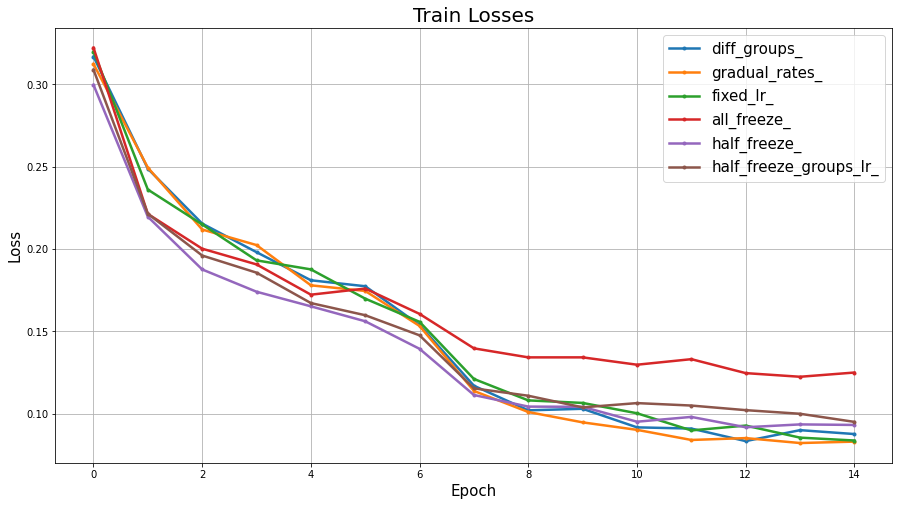

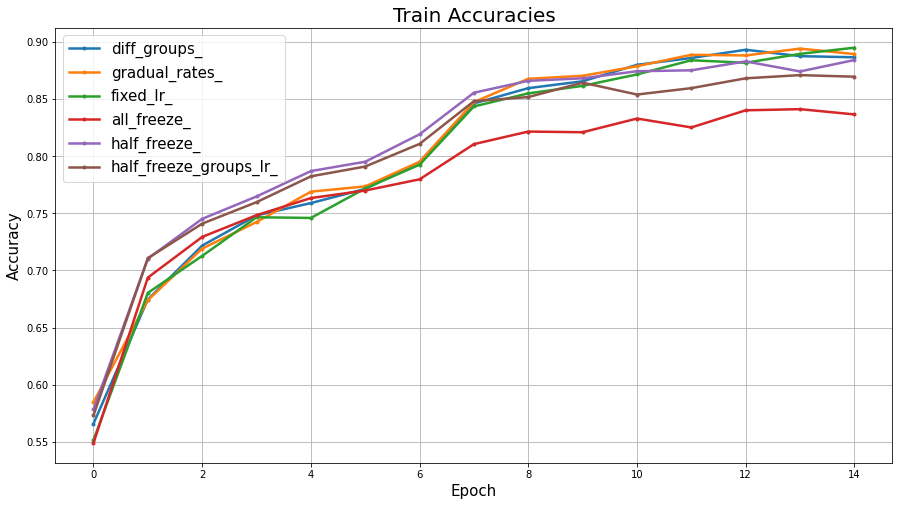

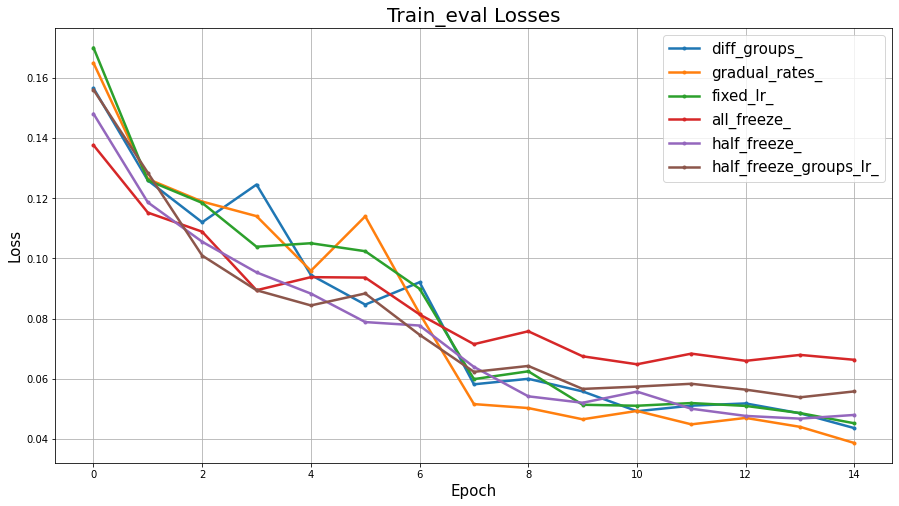

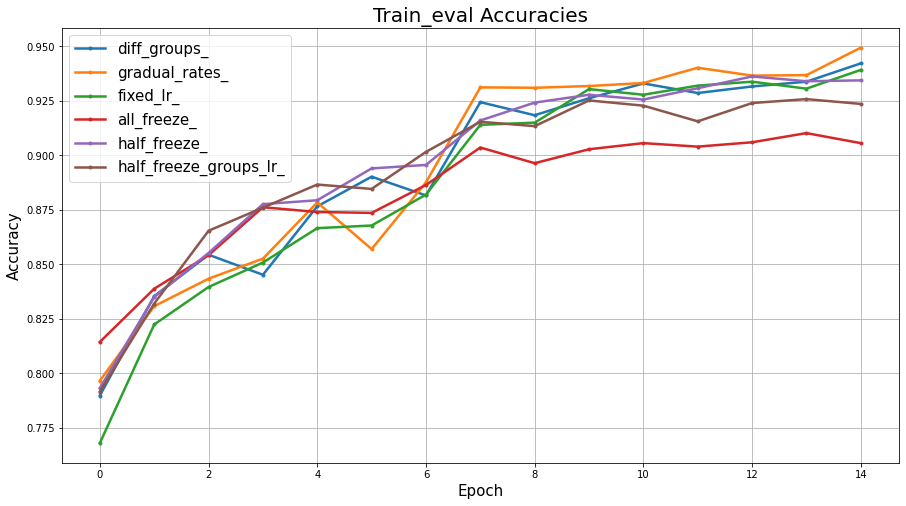

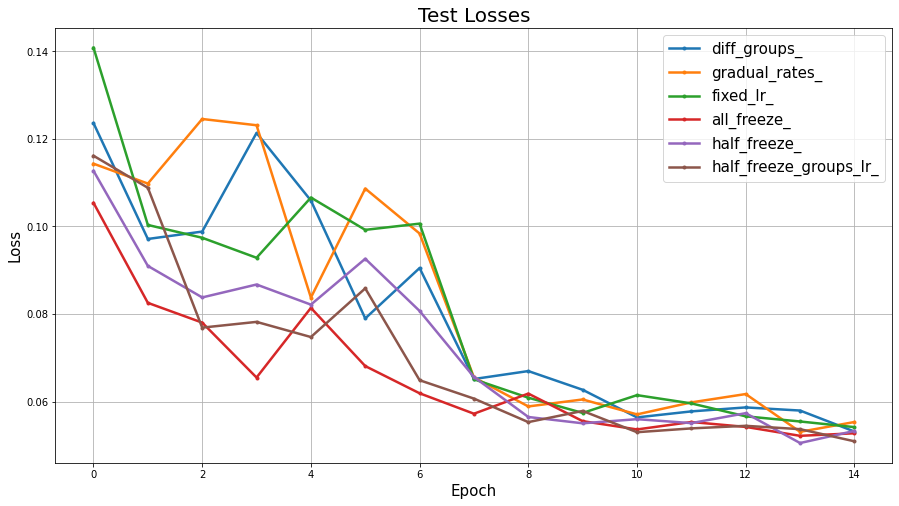

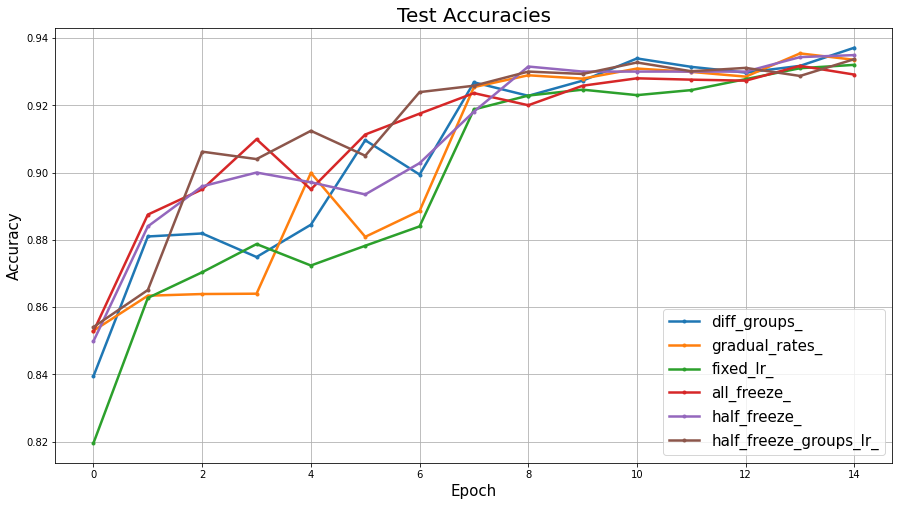

In [119]:
plot_graphics('densenet')

В принципе все способы примерно получились одинаковыми, все выходят на плато где то начиная с 8ой эпохи. Однако до нее их очень сильно бросает вверх-вниз.

Интересен факт, что в отличие от предыдущих моделей, в этой лучшие результаты показывают переносы обучения без замораживания слоев


##Заключение

В ходе данной работы были рассмотрены различные способы трансфера обучения на примере датасета STL10. Лучший результат показала комбинация из архитектуры DenseNet и групповым темпом обучения. Также важным наблюдением является, что что заморозка не всегда дает прирост качества, нужно изучать отдельные архитектуры. Дальнейшим предметом изучения может являться поиск оптимального процента замороженных слоев и изучение стратегии изменения шага обучения на оставшихся. 
Если располагать архитектуры по степени точности, то наименее точным оказался ResNet, после чего идет VGG, затем DenseNet. Однако, нельзя сказать что это определяет выбор модели, так как по времени обучения они расположены в таком же порядке (причем ResNet обучается чуть ли не в 4 раза быстрее, например, DenseNet'a). Опять встает классический выбор в ML - скорость или точность.